Time required for Training = 58.80406475067139
Time required for Linear Search: 0.00067901611328125
Time required for Binary Search: 0.00017786026000976562
Time required for Learned Index: 0.013401031494140625


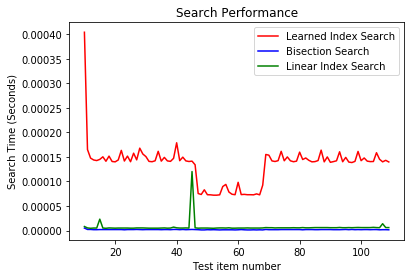

In [0]:
import time
import os
import random
import math
import torch
import torch.autograd
import torch.nn.functional as F
from torch.autograd import Variable
from bisect import bisect_left
import matplotlib.pyplot as plt


#Functions for dataset Generation
#################################

def generate_dataset(N):
    dataset = [lognormal() for _ in range(N)]
    #dataset = [exponential() for _ in range(N)]
    #dataset = [laplace() for _ in range(N)]
    #dataset = [uniform() for _ in range(N)]
    #dataset = [gaussian() for _ in range(N)]
    dataset = sorted(dataset)
    def KVrand():
        x = random.choice(dataset)
        y = dataset.index(x)
        return x, y
    return dataset, KVrand

def exponential(lambda1=1.0):
    u = random.random()
    x = - math.log(u) / lambda1
    return x 

def lognormal(mu=0, sigma=5.0):
    x = random.lognormvariate(mu, sigma)
    return x
  
def uniform(a=0.0,b=10.0):
    x = random.uniform(a,b)
    return x

def gaussian(mu=0, sigma=5.0):
    x = random.gauss(mu, sigma)
    return x

def laplace():
    u = random.random()
    if(u<=0.5):
        x = math.log(2*u)
    else:
        x = -math.log(2-2*u)    
    return x


#Functions for Neural Network Configuration
###########################################

def create_NN(dim=128):
    NN = torch.nn.Sequential(torch.nn.Linear(1, dim),torch.nn.ReLU(),torch.nn.Linear(dim, 1),)
    return NN


def to_tensor(x):   
    return torch.unsqueeze(Variable(torch.Tensor(x)), 1)


#Traditional Search Functions
#############################

def linear_search(x, dataset):
    for idx, n in enumerate(dataset):
        if n > x:
            break
    return idx - 1


def binary_search(x, dataset):
    i = bisect_left(dataset, x)
    if i:
        return i - 1
    raise ValueError

#Main
#####

def main():
    N = 100
    lr = 0.001
    batch_no = 0
    LF_x = []
    LF_y = []  
    minloss = N
    
    
    dataset, KVrand = generate_dataset(N)
    NN = create_NN()
    optimizer = torch.optim.Adam(NN.parameters(), lr=lr)
    
#Training
#########

    start = time.time()
    try:
        while True:
            batch_no = batch_no + 1
            batch_x = []; batch_y = []
            for _ in range(256):
                x, y = KVrand()
                batch_x.append(x)
                batch_y.append(y)

            batch_x = to_tensor(batch_x)
            batch_y = to_tensor(batch_y)

            Predicted_idx = NN(batch_x) * N

            output = F.smooth_l1_loss(Predicted_idx, batch_y)
            loss = output.data
                      
            if (minloss>loss.item()):
               minloss=loss.item()
               #print('Minloss =',minloss,'at',time.time())

            #print(loss, minloss,'at',time.time())  
            
            LF_x.append(batch_no)
            LF_y.append(loss)
            
            if (loss.item()<1.0):
                break
            
            optimizer.zero_grad()
            output.backward()
            optimizer.step()
    except KeyboardInterrupt:
        pass
    end = time.time()
    TrainingTime = end - start
    print('Time required for Training =', TrainingTime)

#Testing
########

    def test(x):
        start = time.time()
        Predicted_idx = NN(to_tensor([x])) * N
        end = time.time()
        tp = end - start
        start = time.time()
        idx1 = binary_search(x, dataset)
        end = time.time()
        tb = end - start
        start = time.time()
        idx2 = linear_search(x, dataset)
        end = time.time()
        ti = end - start
        #print('for x=', x,'BSearch:', idx1, 'IdxSearch:', idx2, 'Predicted:', float(Predicted_idx.data[0]))
        return ti,tb,tp

    timeI=0
    timeB=0
    timeP=0
    TF_x = []
    TF_y1 = []
    TF_y2 = []
    TF_y3 = []
    for x in range(10,110):
        #ti,tb,tp = test(random.choice(dataset))
        ti,tb,tp = test(float(x/100))
        timeI=timeI+ti
        timeB=timeB+tb
        timeP=timeP+tp
        TF_x.append(x)
        TF_y1.append(tp)
        TF_y2.append(tb)
        TF_y3.append(ti)
#        TF_y1.append(timeP)
#        TF_y2.append(timeB)
#        TF_y3.append(timeI)

    print('Time required for Linear Search:', timeI)
    print('Time required for Binary Search:', timeB)
    print('Time required for Learned Index:', timeP)

    plt.plot(TF_x, TF_y1, 'r', label='Learned Index Search')
    plt.plot(TF_x, TF_y2, 'b', label='Bisection Search') 
    plt.plot(TF_x, TF_y3, 'g', label='Linear Index Search')
    plt.xlabel('Test item number')
    plt.ylabel('Search Time (Seconds)')
#    plt.ylabel('Cumulative Search Time (Seconds)')
    plt.title('Search Performance')
    plt.legend(loc='best')
    plt.show()

if __name__ == '__main__':
    main()